In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [5]:
# Load results of the fitting procedure

subject = 1
volume_space=True

fitting_type = 'full_midlevel_plus_clip_RN50_best_layer_pca'

out = load_fits.load_fit_results(subject, fitting_type, n_from_end=0, verbose=True);
# load_fits.print_output_summary(out)
fig_save_folder=None
roi_def = roi_utils.nsd_roi_def(subject,verbose=False) 

skip_inds = [10,11,15,23]

loading from /user_data/mmhender/imStat/model_fits/S01/full_midlevel_plus_clip_RN50_best_layer_pca/Feb-05-2022_2224_22/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'use_pca_st_feats', 'use_pca_pyr_feats_hl', 'pyramid_feature_info', 'group_all_hl_feats', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn', 'clip_layer_name', 'clip_model_architecture', 'use_pca_clip_feats'])


In [8]:
out.keys()

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'use_pca_st_feats', 'use_pca_pyr_feats_hl', 'pyramid_feature_info', 'group_all_hl_feats', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn', 'clip_layer_name', 'clip_model_architecture', 'use_pca_clip_feats'])

In [6]:
[np.any(out['val_r2'][out['best_layer_each_voxel']==ll,:]==0) for ll in range(16)]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

In [7]:
out['voxel_subset_is_done_val']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False])

In [6]:
np.array(out['partial_version_names'])

array(['full_combined_model', 'just_gabor_solo', 'leave_out_gabor_solo',
       'just_pyramid_texture', 'leave_out_pyramid_texture',
       'pyramid_texture_just_lower-level_no_other_modules',
       'pyramid_texture_just_higher-level_no_other_modules',
       'pyramid_texture_just_lower-level_plus_other_modules',
       'pyramid_texture_just_higher-level_plus_other_modules',
       'just_sketch_tokens', 'leave_out_sketch_tokens', 'just_clip',
       'leave_out_clip'], dtype='<U52')

['leave_out_gabor_solo'
 'pyramid_texture_just_higher-level_plus_other_modules'
 'pyramid_texture_just_lower-level_plus_other_modules'
 'leave_out_sketch_tokens' 'leave_out_clip']
[816, 863, 320, 762, 887]
[96, 49, 592, 150, 25]


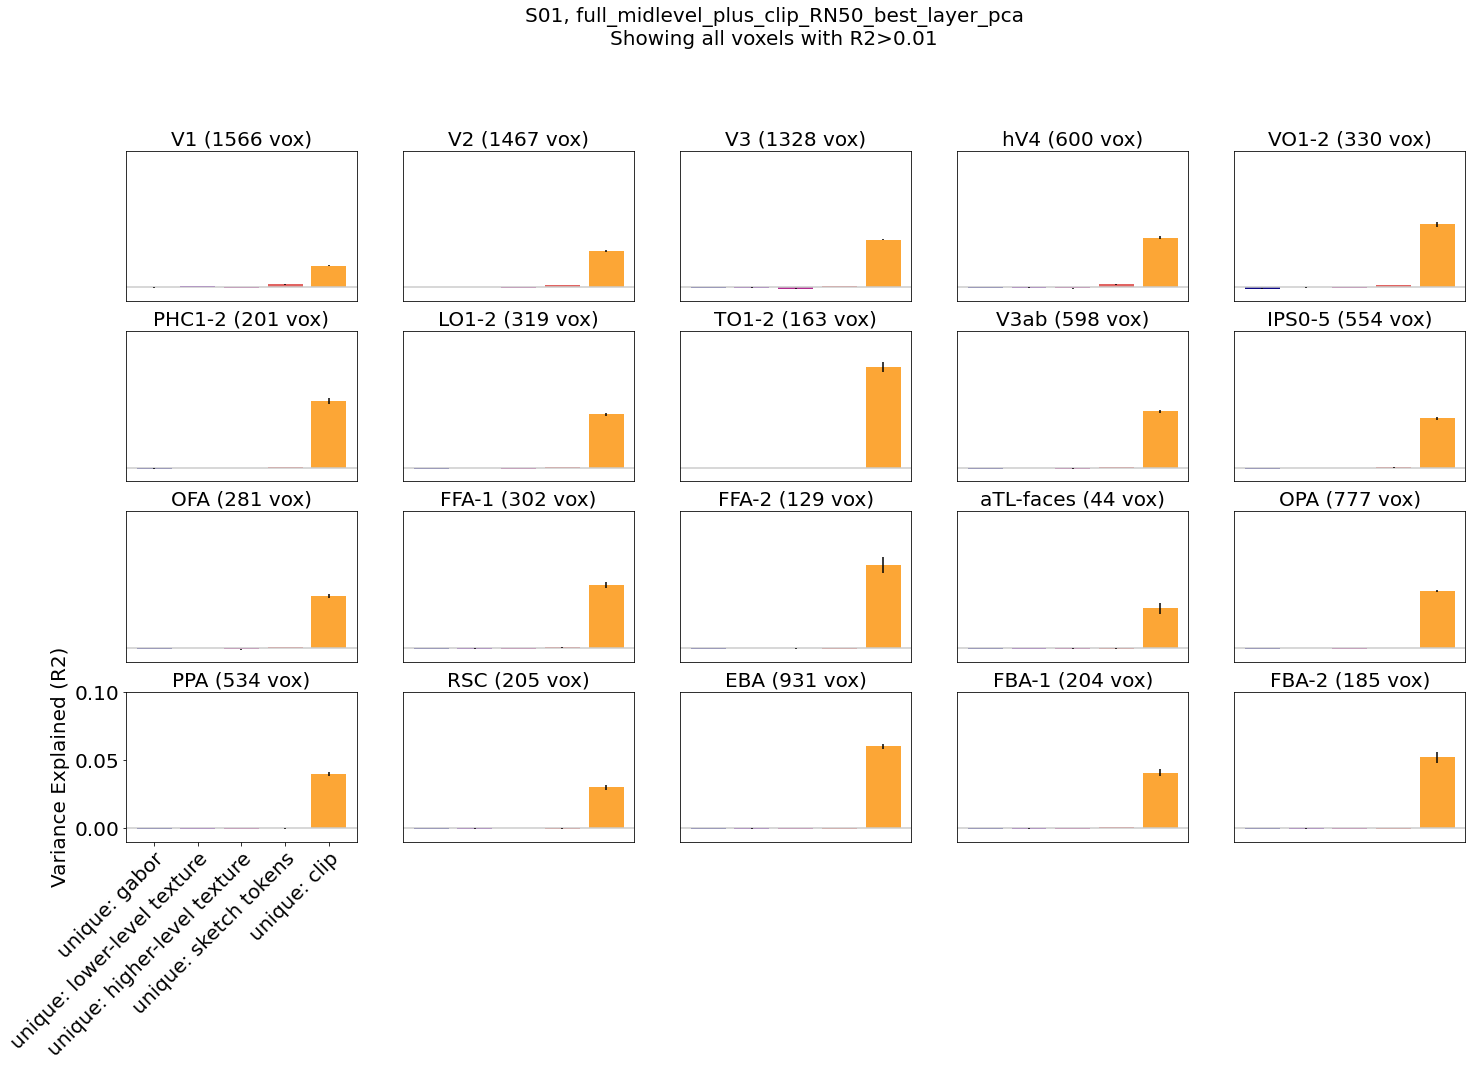

In [9]:

# each of these indices is one feature set left out at a time.
ppinds = [2,8,7,10,12]
print(np.array(out['partial_version_names'])[ppinds])
print([np.sum(out['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', \
            'unique: higher-level texture','unique: sketch tokens', \
           'unique: clip']
var_expl = np.tile(out['val_r2'][:,0:1], [1,5]) - out['val_r2'][:,ppinds]

colors = cm.plasma(np.linspace(0,1,6))
# colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = out['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.10])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subject, fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)


leave_out_clip
just_clip


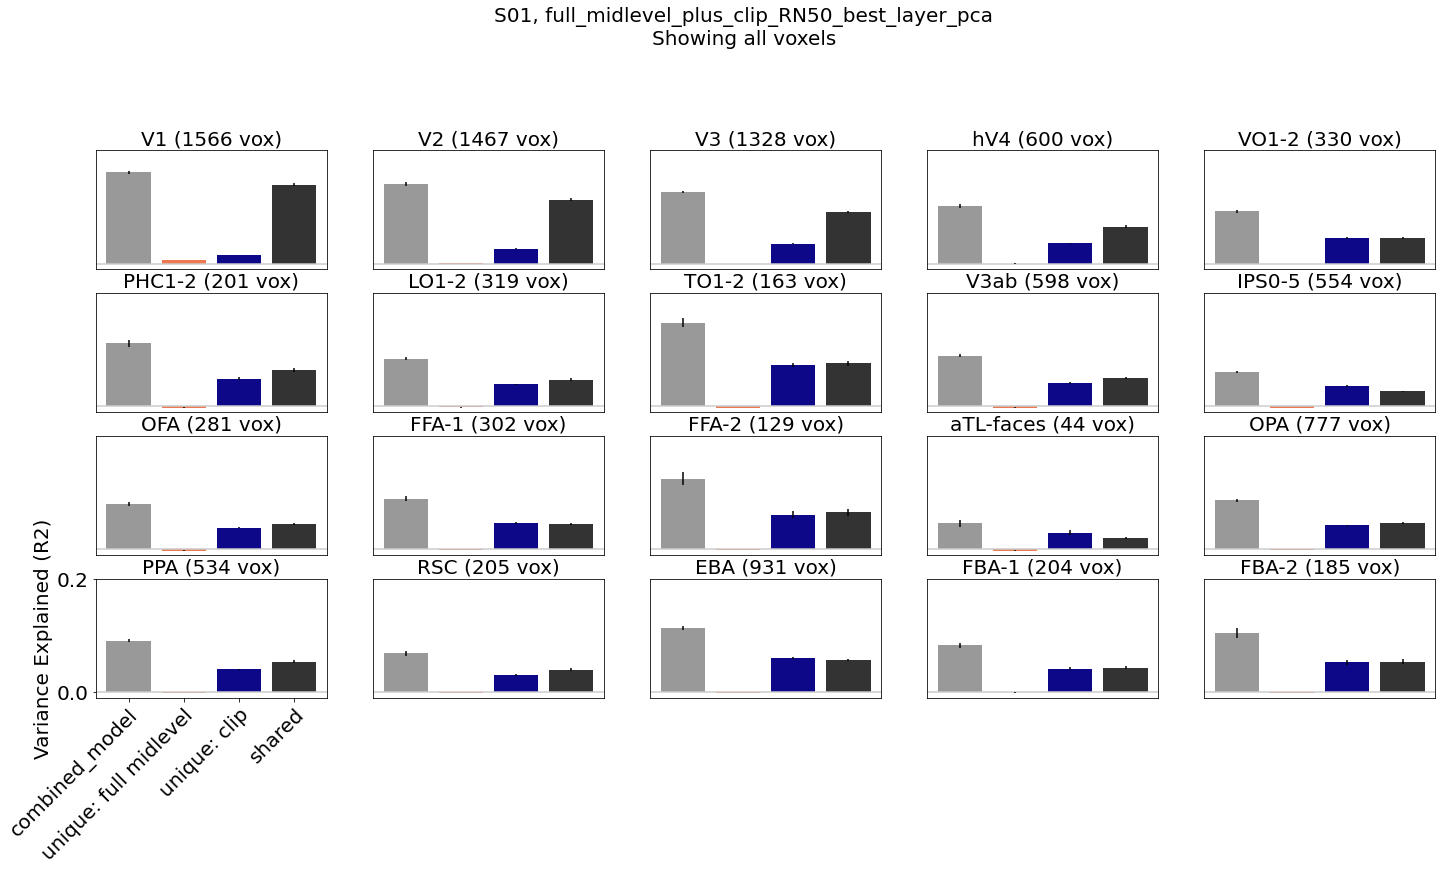

In [11]:
pp0 = 0
pp1 = 12
pp2 = 11
print(np.array(out['partial_version_names'][pp1]))
print(np.array(out['partial_version_names'][pp2]))
name1 = 'full midlevel'
name2 = 'clip'
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.20])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, \
                               skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)


In [3]:

import cortex

port=13333

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [9, 360, 9]

best_layer = out['best_layer_each_voxel']
names += ['best AlexNet layer (individual R2)', 'R2 best single layer alexnet fit']
maps += [(best_layer+1).astype(np.float32),np.sqrt(out['val_r2'][:,11])]
cmaps += ['plasma_r', 'PuBu']
mins += [0, 0]
maxes += [5, 0.8]

pp0 = 0
pp1 = 12
pp2 = 11
print(np.array(out['partial_version_names'][pp1]))
print(np.array(out['partial_version_names'][pp2]))
name1 = 'full midlevel'
name2 = 'alexnet'
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

max_ind = (np.argmax(var_expl[:,1:3], axis=1)+2).astype(np.float32)
max_ind[max_ind==2] = 1.5

# max_ind[bad_voxels] = np.nan

maps += [np.sqrt(var_expl[:,ii]) for ii in range(4)] + [max_ind]

names  += ['Concat model','Unique var: %s'%name1, 'Unique var: %s'%name2, 'Shared variance', \
          'Unique var greater for %s or %s'%(name1, name2)]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins += [0, 0, 0, 0, 0]
maxes += [0.8, 0.8, 0.8, 0.8, 3]

vox2plot = val_r2[:,0]>=0.01
# vox2plot = None

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type='%s + %s'%(name1, name2), \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


leave_out_alexnet
just_alexnet
Data is in 3d volume space
navigate browser to: 127.0.0.1:13333
Started server on port 13333


In [6]:
maps

[array([6.9999995 , 6.9999995 , 0.53988534, ..., 6.9999995 , 0.5398854 ,
        0.92858064], dtype=float32),
 array([ 45. , 225. , 292.5, ..., 337.5, 135. , 157.5], dtype=float32),
 array([5.438822 , 3.5215218, 0.9558881, ..., 3.5215218, 2.2801106,
        1.4763234], dtype=float32),
 array([5., 5., 3., ..., 4., 5., 5.], dtype=float32),
 array([0.08597551, 0.05684042,        nan, ...,        nan, 0.32752714,
        0.3321796 ], dtype=float32),
 array([0.09369741, 0.02582998,        nan, ...,        nan, 0.3311152 ,
        0.33128154], dtype=float32),
 array([3.7248038e-02,           nan, 5.6111002e+09, ...,           nan,
        4.8613038e-02,           nan], dtype=float32),
 array([0.0964276 , 0.03651688,        nan, ...,        nan, 0.1829515 ,
        0.16761763], dtype=float32),
 array([       nan, 0.04355859,        nan, ...,        nan, 0.27166668,
        0.28678846], dtype=float32),
 array([3. , 3. , 1.5, ..., 1.5, 3. , 3. ], dtype=float32)]

Stopping server


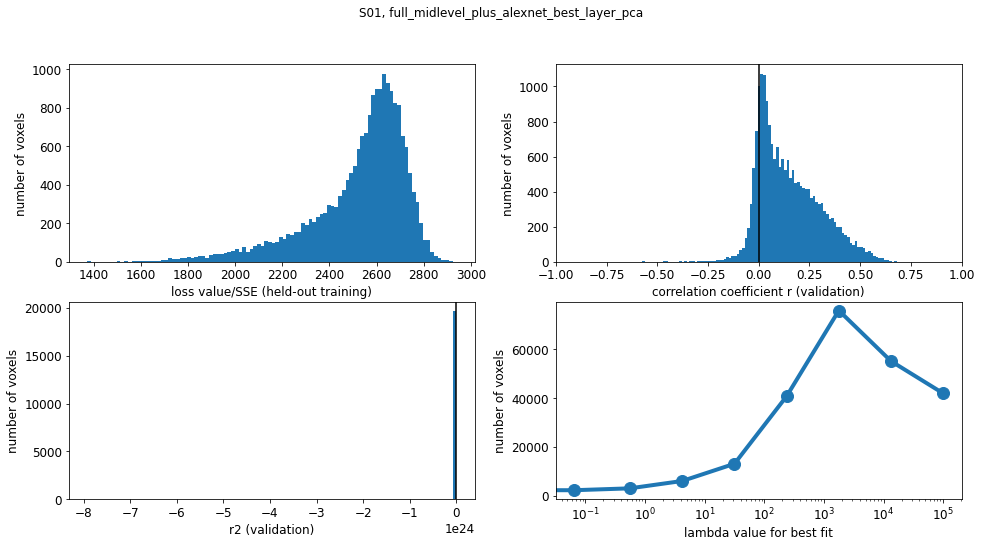

In [3]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out)

In [13]:
np.mean(out['val_r2']<-1)

0.2039369587753416

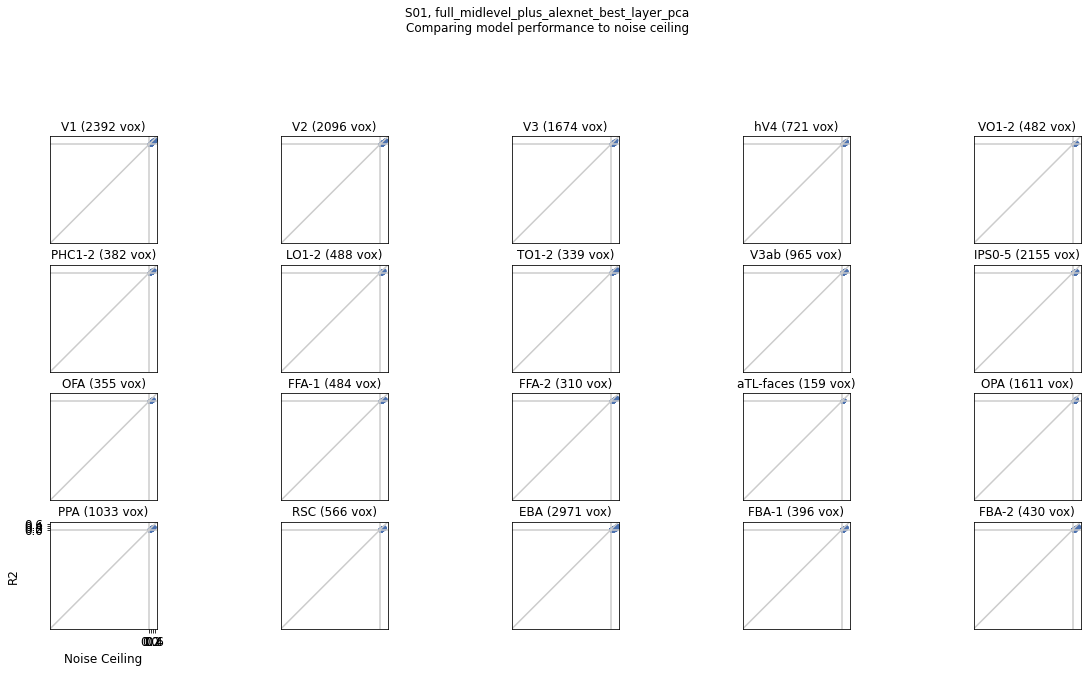

In [11]:
plot_utils.set_all_font_sizes(fs = 12)
axlims =[-10, 0.8]
# axlims = None
summary_plots.plot_r2_vs_nc(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                            fig_save_folder=fig_save_folder,axlims = axlims)